# Projet ségmentation client

Useful links : [Subject](https://simplonline.co/briefs/99595e02-a23d-47bc-86e8-738520a13ce5) | [Original datasets (.csv)](https://drive.google.com/drive/folders/15Q-hhe7kmOtQ_c6Cjw9Vx2NXixn7oNud) <br>
This project was realized by : Théo

Technical specifications :
>- Python3

### Table of content
- [Import des données](#data_import)

----

In [82]:
import pandas as pd
import numpy as np
from datetime import datetime

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

%pwd

'/Users/theoprovost/Desktop/SIMPLON/SIMPLON_REPOS/SIMPLON-P/P03'

---------

### <a name="data_import"></a> Import des données

In [83]:
customers = pd.read_csv('./data/customers.csv')
products = pd.read_csv('./data/products.csv')
transactions = pd.read_csv('./data/transactions.csv')

-----
### Jointure des données

In [84]:
data_inter = customers.merge(transactions)
dataset = data_inter.merge(products)
dataset

,client_id,sex,birth,id_prod,date,session_id,price,categ
0,c_4410,f,1967,0_1455,2021-03-22 14:29:25.189266,s_9942,8.99,0
1,c_4389,m,1984,0_1455,2021-07-09 11:16:18.579726,s_59967,8.99,0
2,c_5019,f,1977,0_1455,2022-01-15 00:01:53.456196,s_149928,8.99,0
3,c_7049,f,1987,0_1455,2021-03-04 14:01:38.698752,s_1637,8.99,0
4,c_5110,f,1982,0_1455,2021-09-05 11:48:41.065009,s_85364,8.99,0
...,...,...,...,...,...,...,...,...
336908,c_7135,m,1996,2_99,2021-07-11 20:56:49.820935,s_61009,84.99,2
336909,c_5828,f,1998,2_99,2021-11-21 01:53:46.967570,s_122697,84.99,2
336910,c_8260,m,1991,0_833,2021-09-27 23:22:40.394509,s_96558,2.99,0
336911,c_8138,f,1984,0_394,2021-11-09 09:02:38.299240,s_116986,2.14,0


-----
### Nettoyage des données

In [85]:
# Checks if any data is NA, if True : dataset.isnull().sum() -> count nb of missing values for each feature
if (dataset.isnull().values.any() != True):
    print('No NA data for each fatures of the dataset.')

# Cast str date to date format
type(dataset['date'][0]) # returns str, then :

dataset['date'] = pd.to_datetime(dataset['date'], errors='coerce')

# Checks the missing dates
na_dates = dataset[dataset['date'].isna()]
bef = na_dates.count()

# Since all those values contain absurd prices, we drop them
na_dates = na_dates[na_dates['price'] < 0]
af = na_dates.count()

if (bef.all() == af.all()):
    dataset = dataset.drop(dataset[dataset['price'] < 0].index)
    
# Checks if duplication based on the client identifier and the timestamp
is_duplicated = dataset.duplicated(subset=['client_id','date']).all()
print(f'Duplicate values ? {is_duplicated}')

No NA data for each fatures of the dataset.
Duplicate values ? False


----
### Création du dataset client

In [90]:
# Add age and recence
dataset['age'] = datetime.now().year - dataset['birth']

# group by client
dataset_client = (dataset.groupby(['client_id','age','sex'])
            .agg(montant = ('price', np.sum), 
                 frequence = ('client_id', 'count'),
                 panier_moyen = ('price', 'mean'),
                 )
            .reset_index())

dataset_client['recence'] = (max(dataset['date']) - dataset['date']).astype('timedelta64[D]')

# total amount spent by category
pivot_sum_cats = pd.pivot_table(dataset, index='client_id', values='price', columns='categ', aggfunc='sum', fill_value=0)
pivot_sum_cats.columns = ['MC0', 'MC1', 'MC2']

dataset_client = pd.merge(dataset_client, pivot_sum_cats, on='client_id')

# tranche_age : age group
bins = [13, 18, 24, 32, 60, 80, 110]
age_labels = ['Adolescent', 'Jeune adulte', 'Adulte', 'Adulte+', 'Senior', 'Senior++']
dataset_client["tranche_age"] = pd.cut(dataset_client['age'], bins, labels=age_labels, right=False)

dataset_client = dataset_client.drop(columns=['client_id'])
dataset_client

,age,sex,montant,frequence,panier_moyen,recence,MC0,MC1,MC2,tranche_age
0,66,m,300.65,20,15.032500,343.0,174.20,71.58,54.87,Senior
1,65,m,586.18,28,20.935000,234.0,124.92,391.27,69.99,Senior
2,29,m,222.87,6,37.145000,44.0,31.38,52.96,138.53,Adulte
3,55,f,980.02,56,17.500357,361.0,169.85,810.17,0.00,Adulte+
4,39,m,1102.45,58,19.007759,176.0,527.81,274.64,300.00,Adulte+
...,...,...,...,...,...,...,...,...,...,...
8595,66,m,119.08,8,14.885000,298.0,55.34,63.74,0.00,Senior
8596,51,f,739.60,42,17.609524,161.0,204.70,534.90,0.00,Adulte+
8597,27,f,572.89,23,24.908261,181.0,84.86,158.92,329.11,Adulte
8598,20,m,1527.69,28,54.560357,52.0,88.17,108.06,1331.46,Jeune adulte


------
### Encodage ordinal

In [65]:
from sklearn.preprocessing import LabelEncoder

In [66]:
encoder = LabelEncoder()

dataset_client['sex'] = encoder.fit_transform(dataset_client['sex']) 
dataset_client['tranche_age'] = encoder.fit_transform(dataset_client['tranche_age'])

------------
### Exploration et visualisation des donnés 

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

dataset = dataset_client

In [68]:
dataset.describe()

,age,sex,montant,frequence,panier_moyen,MC0,MC1,MC2,tranche_age
count,8600.000000,8600.000000,8600.000000,8600.000000,8600.000000,8600.000000,8600.000000,8600.000000,8600.000000
mean,42.739302,0.479186,674.020671,39.152674,21.803379,259.270076,261.323769,153.426827,2.229302
std,16.908755,0.499596,2565.848732,156.434080,14.698417,1261.928137,846.377588,1382.312608,1.104380
min,17.000000,0.000000,4.150000,1.000000,4.150000,0.000000,0.000000,0.000000,0.000000
25%,29.000000,0.000000,275.765000,14.000000,13.226929,47.727500,95.850000,0.000000,2.000000
50%,42.000000,0.000000,501.310000,25.000000,15.711256,132.520000,184.405000,0.000000,2.000000
75%,55.000000,1.000000,870.650000,47.000000,21.832368,301.610000,340.370000,115.142500,3.000000
max,92.000000,1.000000,162007.340000,12855.000000,181.990000,109657.030000,52309.000000,125206.730000,5.000000


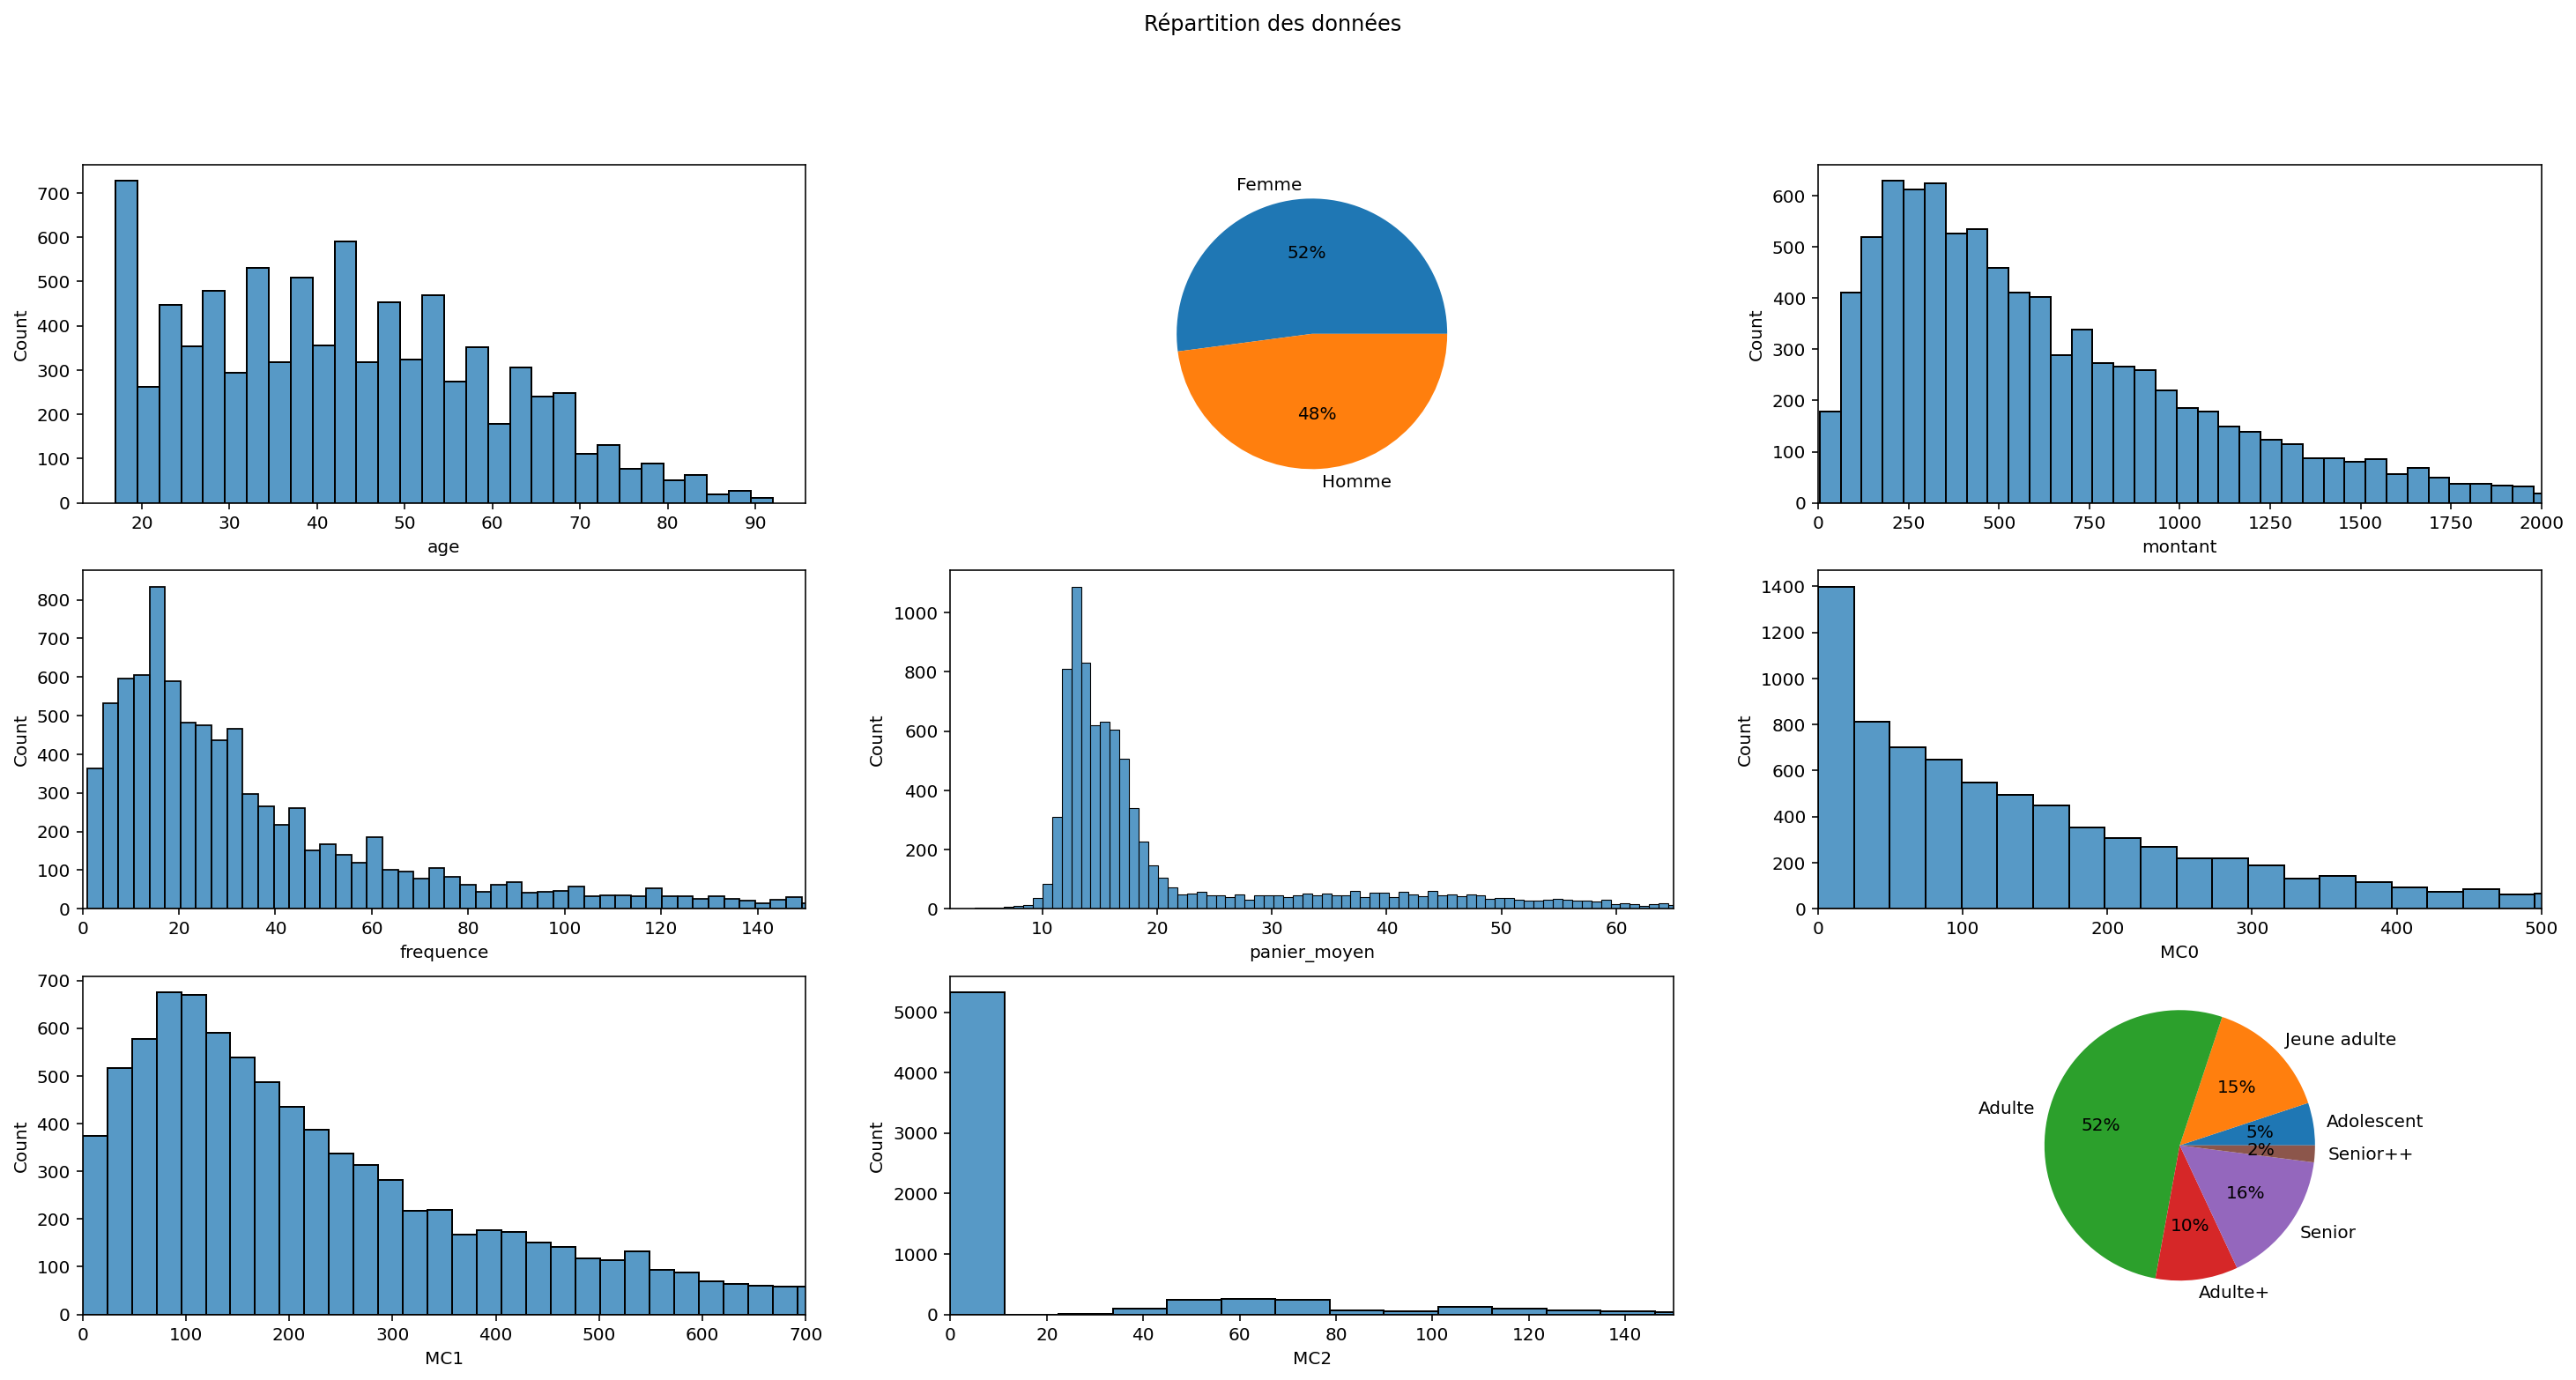

In [69]:
fig, axes = plt.subplots(3, 3, figsize=(25, 12))
fig.suptitle('Répartition des données')

# Âge
sns.histplot(ax=axes[0][0], x=dataset['age'])

# Sex
df_sex = dataset.groupby('sex').size().reset_index(name='counts')
axes[0][1].pie(df_sex['counts'], labels=['Femme', 'Homme'], autopct='%1.0f%%')

# Montant
axes[0][2].set(xlim=(0, 2000))
sns.histplot(ax=axes[0][2], data=dataset['montant'])

# Fréquence
axes[1][0].set(xlim=(0, 150))
sns.histplot(ax=axes[1][0], x=dataset['frequence'])

# Panier moyen
axes[1][1].set(xlim=(2, 65))
sns.histplot(ax=axes[1][1], x=dataset['panier_moyen'])

# MC0
axes[1][2].set(xlim=(0, 500))
sns.histplot(ax=axes[1][2], x=dataset['MC0'])

# MC1
axes[2][0].set(xlim=(0, 700))
sns.histplot(ax=axes[2][0], x=dataset['MC1'])

# MC2
axes[2][1].set(xlim=(0, 150))
sns.histplot(ax=axes[2][1], x=dataset['MC2'])

# Tranche d'âge
df_ta = dataset.groupby('tranche_age').size().reset_index(name='counts')
axes[2][2].pie(df_ta['counts'], labels=age_labels, autopct='%1.0f%%')

plt.show()

------
### Standardisation des données

In [70]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(dataset), columns=dataset.columns)

-----
### Visualisation de la matrice de corrélation

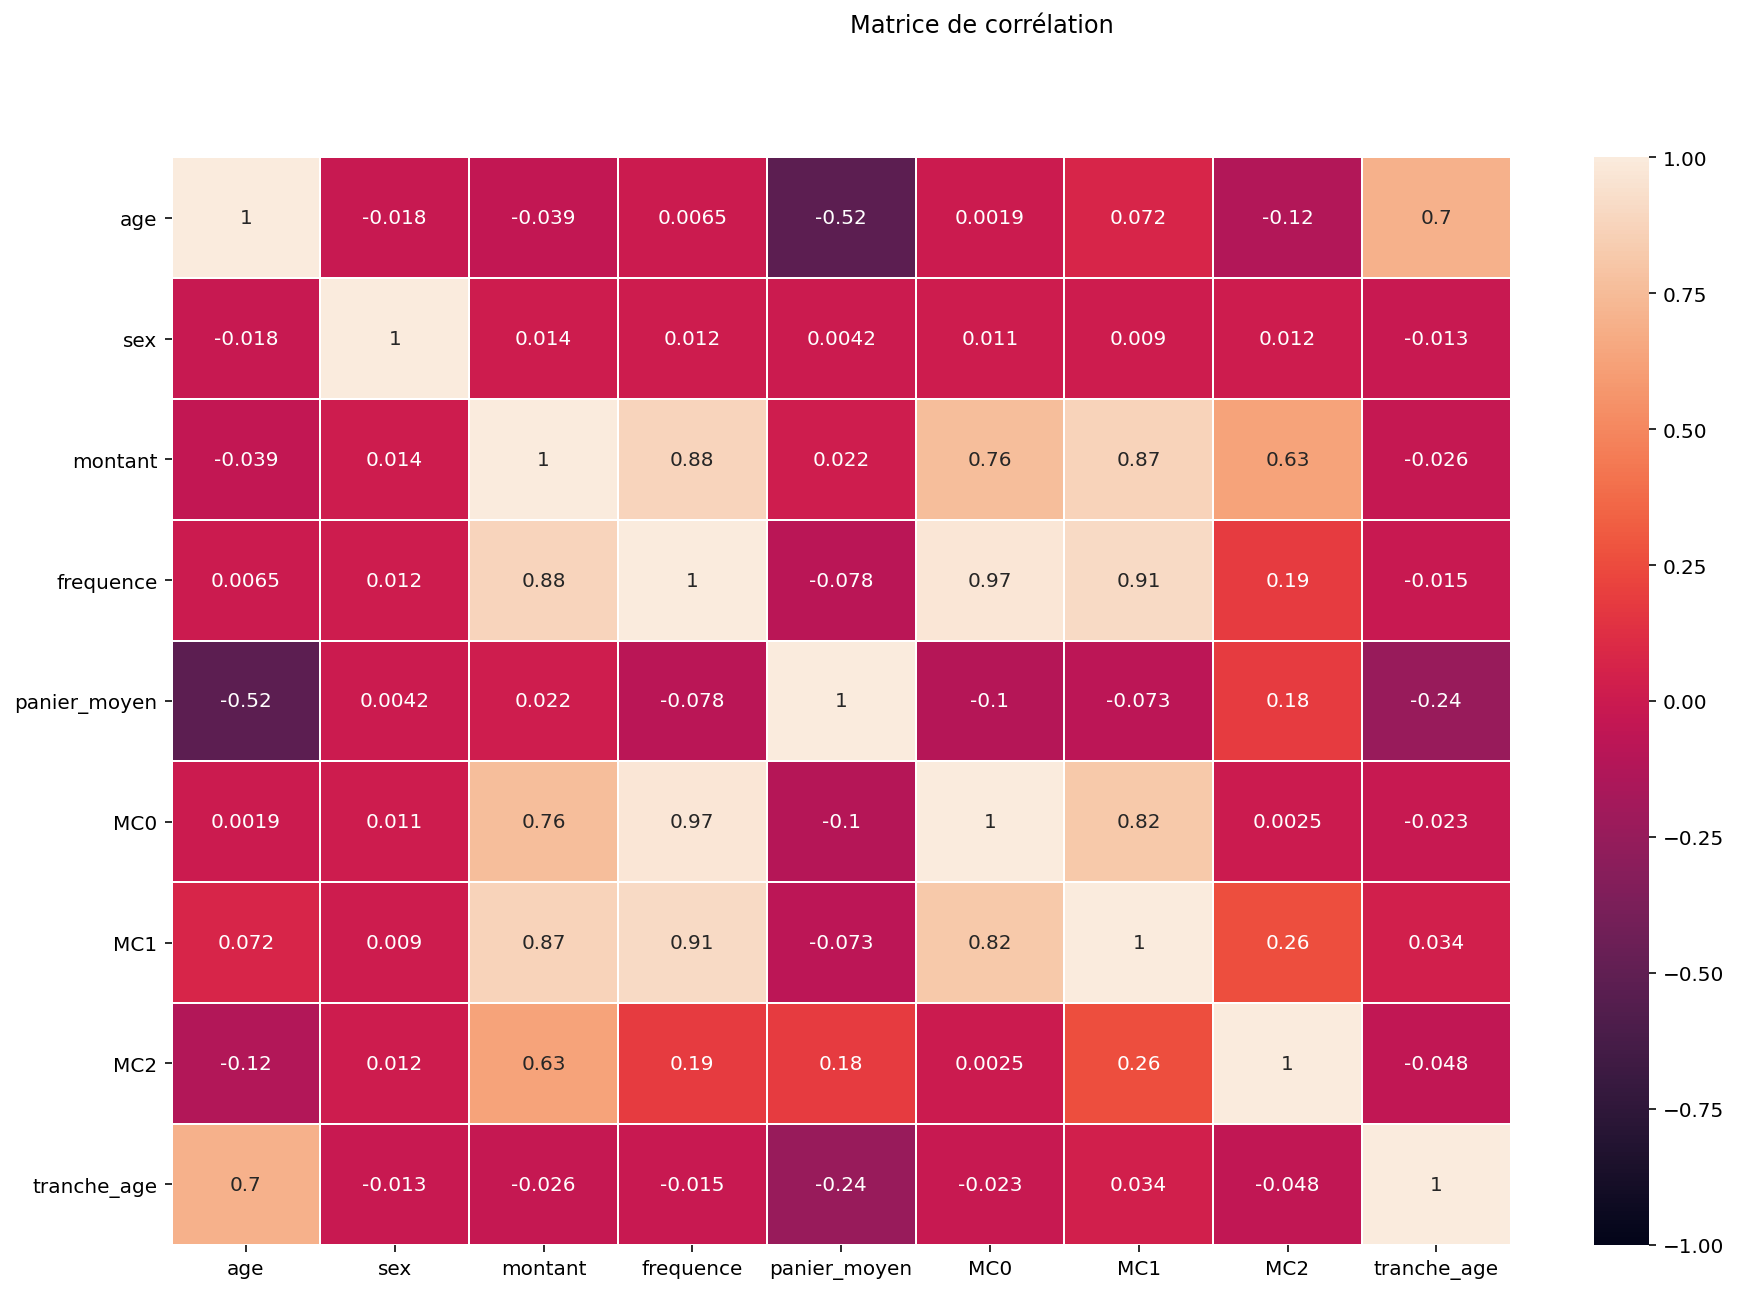

In [71]:
scaled_dataset_corr = scaled_data.corr()

plt.figure(figsize=(15, 10))
plt.suptitle('Matrice de corrélation')
sns.heatmap(scaled_dataset_corr, annot=True, linewidths=.5, vmin=-1, vmax=1)

plt.show()

----
### Clustering

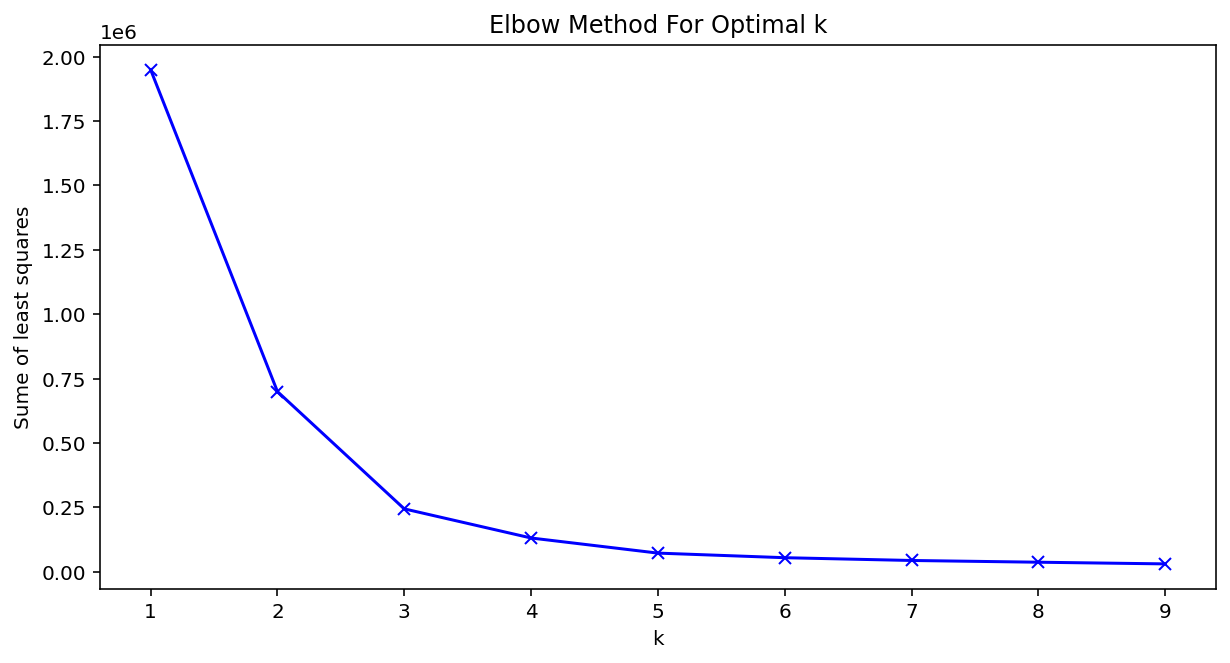

In [72]:
from sklearn.cluster import KMeans

sum_least_squares = []
K = range(1, 10)

for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(scaled_data)
    sum_least_squares.append(km.inertia_)
 
plt.figure(figsize=(10, 5))
plt.plot(K, sum_least_squares, 'bx-')
plt.xlabel('k')
plt.ylabel('Sume of least squares')
plt.title('Elbow Method For Optimal k')
plt.show()

In [99]:
from sklearn.metrics import silhouette_score

X = scaled_data

model = KMeans(n_clusters=3)
model.fit(X)

#score = silhouette_score(X, model.labels_, metric='euclidean')
#print(f'Silhouette Score: {score}')

dataset_client["cluster"] = model.labels_
dataset_client.groupby('cluster').agg({
    'recence': 'mean',
    'frequence':'mean',
    'montant':['mean', 'count', 'max', 'min']}).round(2)

recence frequence    montant                            
           mean      mean       mean count        max        min
cluster                                                         
0        173.25     37.37     638.56  8598   73197.34       4.15
1        337.00   2562.00  144257.21     1  144257.21  144257.21
2        346.00  12855.00  162007.34     1  162007.34  162007.34

-----
### Analyse des résultats